In [1]:
# load libraries

import sys

import numpy as np
np.set_printoptions(threshold=np.inf)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

from collections import Counter


In [2]:
# renaming columns to identify each feature properly. 
# here gain and loss columns defines the capital_gain and capital_loss on financial asssts respectively.
col_name = ['Age','Employment_Type', 'Weighing_Factor', 'Level_of_Education', 'Duration_of_Education', 'Maritial_Status',
            'Employment_Area', 'Partnership', 'Ethnicity', 'Gender', 'Capital_Gain', 'Capital_Loss', 'Weekely_Working_Hours', 'Country_of_Birth',
           'Income']

# loading data from given file
# Removing initial space from whole dataframe
income_df = pd.read_csv('einkommen.train', names=col_name, skipinitialspace = True) 

In [3]:
# look at data
income_df.head()

,Age,Employment_Type,Weighing_Factor,Level_of_Education,Duration_of_Education,Maritial_Status,Employment_Area,Partnership,Ethnicity,Gender,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Country_of_Birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Number of rows: 30000 and number of columns: 15
income_df.shape

(30000, 15)

In [5]:
# using info() to see some general information like number of null values, dtype etc. about the data.
income_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    30000 non-null  int64 
 1   Employment_Type        30000 non-null  object
 2   Weighing_Factor        30000 non-null  int64 
 3   Level_of_Education     30000 non-null  object
 4   Duration_of_Education  30000 non-null  int64 
 5   Maritial_Status        30000 non-null  object
 6   Employment_Area        30000 non-null  object
 7   Partnership            30000 non-null  object
 8   Ethnicity              30000 non-null  object
 9   Gender                 30000 non-null  object
 10  Capital_Gain           30000 non-null  int64 
 11  Capital_Loss           30000 non-null  int64 
 12  Weekely_Working_Hours  30000 non-null  int64 
 13  Country_of_Birth       30000 non-null  object
 14  Income                 30000 non-null  object
dtypes: int64(6), object

In [6]:
#replacing '?' with Nan
#income_df_new = income_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

income_df.replace('?', np.nan, inplace=True)

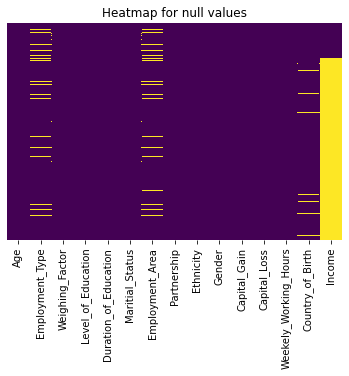

In [7]:
# check which column has null values
# categorical column Employment_Type, Employment_Area and Country_of_Birth have few values missing.

ax = plt.axes()
sns.heatmap(income_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
ax.set_title('Heatmap for null values')
plt.show()

In [8]:
# replace Income column values with 0 and 1

income_df['Income'].replace({'<=50K':0, '>50K':1}, inplace=True)

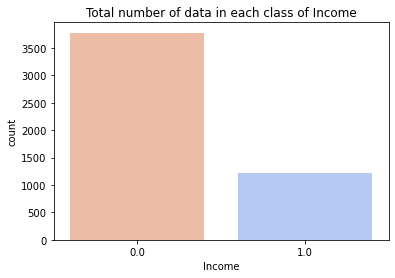

In [9]:
# count the number each class of Income with given data.

ax = plt.axes()
sns.countplot(x=income_df['Income'], palette = 'coolwarm_r')
ax.set_title('Total number of data in each class of Income')
plt.show()

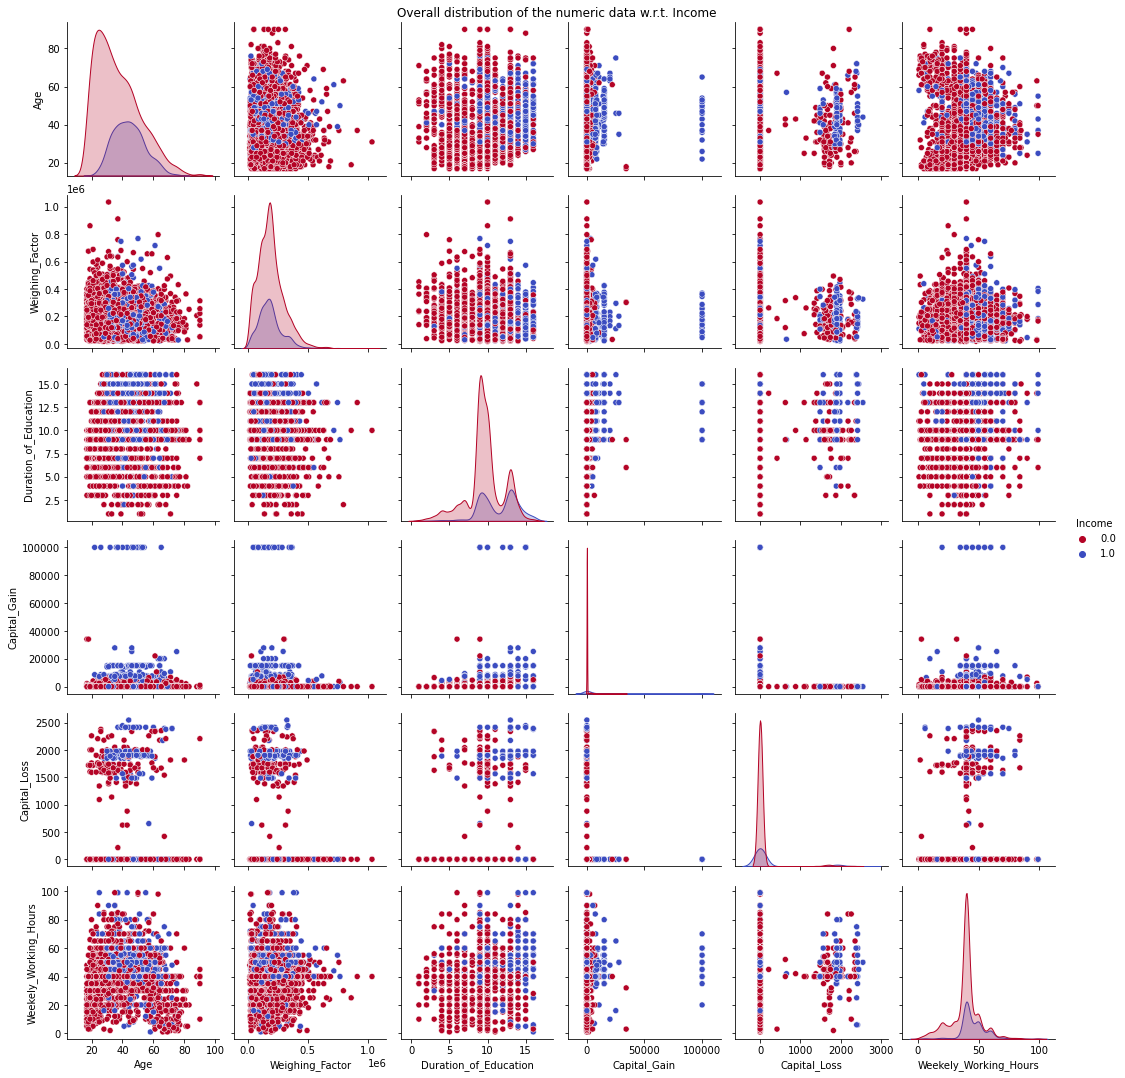

In [10]:
# look at the overall distribution of the data w.r.t. Income.

odd = sns.pairplot(income_df, hue ='Income', palette = 'coolwarm_r')
odd.fig.suptitle('Overall distribution of the numeric data w.r.t. Income', y=1)
plt.show()

In [11]:
# Check how other numerical attributes are related to Income.

income_corr = income_df.corr()
income_corr

,Age,Weighing_Factor,Duration_of_Education,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Income
Age,1.000000,-0.075316,0.036176,0.077909,0.056645,0.067212,0.229018
Weighing_Factor,-0.075316,1.000000,-0.044314,0.001136,-0.012113,-0.020095,-0.025699
Duration_of_Education,0.036176,-0.044314,1.000000,0.123727,0.079821,0.145925,0.317528
Capital_Gain,0.077909,0.001136,0.123727,1.000000,-0.031539,0.079008,0.218064
Capital_Loss,0.056645,-0.012113,0.079821,-0.031539,1.000000,0.054022,0.159681
Weekely_Working_Hours,0.067212,-0.020095,0.145925,0.079008,0.054022,1.000000,0.241162
Income,0.229018,-0.025699,0.317528,0.218064,0.159681,0.241162,1.000000


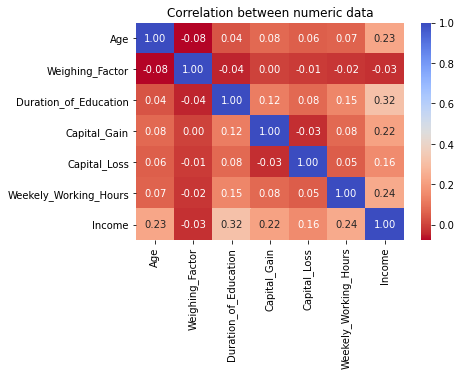

In [12]:
# visualize above correlation using heatmap
# attribute Duration_of_Education, Weekly_Working_Hour and Age are top three attributes that are positively corelated to Income

ax = plt.axes()
sns.heatmap(income_corr, cmap='coolwarm_r', annot=True, fmt='.2f')
ax.set_title('Correlation between numeric data')
plt.show()

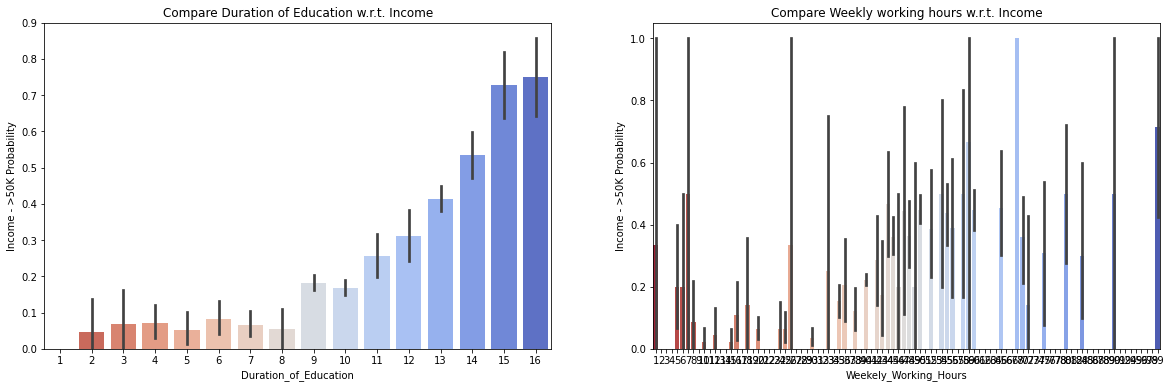

In [13]:
# comparing Duration_of_Education and Weekely_Working_Hours with Income

fig, ax = plt.subplots(1,2, figsize=(20,6))

doe_i = sns.barplot(x='Duration_of_Education', y='Income', data=income_df, ax=ax[0], palette='coolwarm_r')
doe_i.set_ylabel('Income - >50K Probability')
ax[0].set_title('Compare Duration of Education w.r.t. Income')

wwh_i = sns.barplot(x='Weekely_Working_Hours', y='Income', data=income_df, ax=ax[1], palette='coolwarm_r')
wwh_i.set_ylabel('Income - >50K Probability')
ax[1].set_title('Compare Weekly working hours w.r.t. Income')

plt.show()

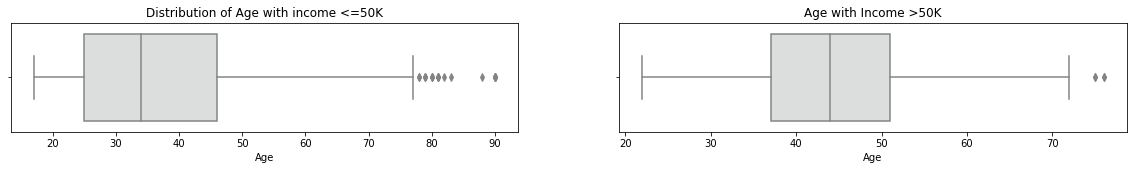

In [14]:
# Comparing Age with Income
income_0 = income_df[income_df['Income'] == 0]
income_1 = income_df[income_df['Income'] == 1]

fig, ax = plt.subplots(1,2, figsize=(20,2))
age_i0 = sns.boxplot(x='Age', data=income_0, ax=ax[0], palette='coolwarm_r')
ax[0].set_title('Distribution of Age with income <=50K')

age_i1 = sns.boxplot(x='Age', data=income_1, ax=ax[1], palette='coolwarm_r')
ax[1].set_title('Age with Income >50K')
plt.show()

In [15]:
# Categorical attributes analysis
# Checking columns with null values first

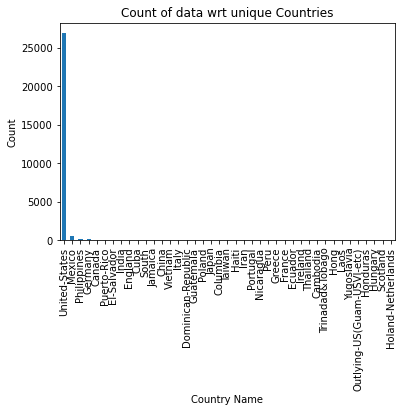

In [16]:
# Check how many unique Coutries people belongs too

income_df['Country_of_Birth'].value_counts().plot.bar()
plt.title('Count of data wrt unique Countries')
plt.xlabel('Country Name')
plt.ylabel('Count')
plt.show()

In [17]:
# As majority belongs to United States, updating missing value with same value using mode.

income_df['Country_of_Birth'].fillna(income_df['Country_of_Birth'].mode()[0], inplace=True)

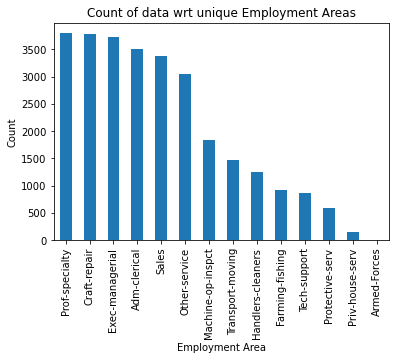

In [18]:
# Check how many unique Employment Areas people belongs too

income_df['Employment_Area'].value_counts().plot.bar()
plt.title('Count of data wrt unique Employment Areas')
plt.xlabel('Employment Area')
plt.ylabel('Count')
plt.show()

In [19]:
# As there is no majority available for any option, updating null values with a new value called EA.

income_df['Employment_Area'].fillna('EA', inplace=True)

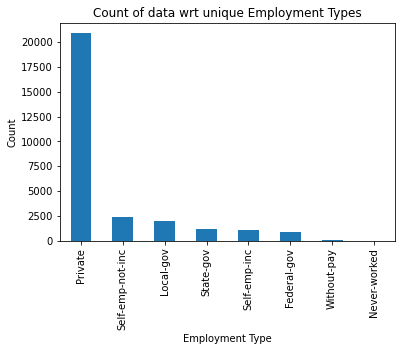

In [20]:
# Check how many unique Employment Types people belongs too

income_df['Employment_Type'].value_counts().plot.bar()
plt.title('Count of data wrt unique Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.show()

In [21]:
# As majority belongs to Private, updating missing value with same value using mode.

income_df['Employment_Type'].fillna(income_df['Employment_Type'].mode()[0], inplace=True)

In [22]:
# Checking if all columns are non null now accept Income.

income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    30000 non-null  int64  
 1   Employment_Type        30000 non-null  object 
 2   Weighing_Factor        30000 non-null  int64  
 3   Level_of_Education     30000 non-null  object 
 4   Duration_of_Education  30000 non-null  int64  
 5   Maritial_Status        30000 non-null  object 
 6   Employment_Area        30000 non-null  object 
 7   Partnership            30000 non-null  object 
 8   Ethnicity              30000 non-null  object 
 9   Gender                 30000 non-null  object 
 10  Capital_Gain           30000 non-null  int64  
 11  Capital_Loss           30000 non-null  int64  
 12  Weekely_Working_Hours  30000 non-null  int64  
 13  Country_of_Birth       30000 non-null  object 
 14  Income                 5000 non-null   float64
dtypes:

In [23]:
# Now continuing analysis of categorical columns without any null values

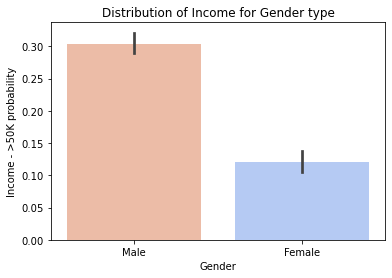

In [24]:
# See the distribution of gender wrt Income

sns.barplot(x='Gender', y='Income', data=income_df, palette='coolwarm_r')
plt.title('Distribution of Income for Gender type')
plt.ylabel('Income - >50K probability')
plt.show()

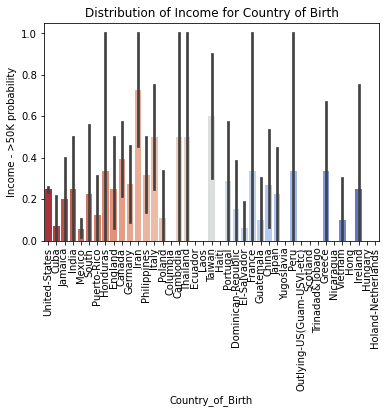

In [25]:
# See the distrinution of Country of Birth wrt Income

sns.barplot(x='Country_of_Birth', y='Income', data=income_df, palette='coolwarm_r')
plt.title('Distribution of Income for Country of Birth')
plt.ylabel('Income - >50K probability')
plt.xticks(rotation=90)
plt.show()

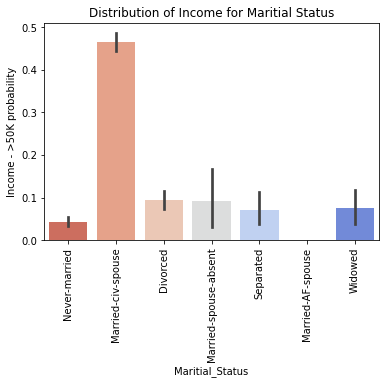

In [26]:
# See the distrinution of Maritial Status wrt Income

sns.barplot(x='Maritial_Status', y='Income', data=income_df, palette='coolwarm_r')
plt.title('Distribution of Income for Maritial Status')
plt.ylabel('Income - >50K probability')
plt.xticks(rotation=90)
plt.show()

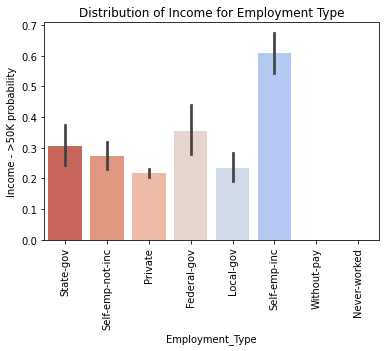

In [28]:
# See the distrinution of Employment Type wrt Income

sns.barplot(x='Employment_Type', y='Income', data=income_df, palette='coolwarm_r')
plt.title('Distribution of Income for Employment Type')
plt.ylabel('Income - >50K probability')
plt.xticks(rotation=90)
plt.show()

In [34]:
# Classifying Maritial Status in two categories as Never-married, Divorced, separated and widowed can identify that a person 
# is single 
# and 
# Married-civ-spouse, Married-spouse-absent and Married-AF-spouse can be identified as married. 

income_df["Maritial_Status"] = income_df["Maritial_Status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
income_df["Maritial_Status"] = income_df["Maritial_Status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')

In [35]:
# converting categorical columns into numerical columns

# At this beginning considering 3 categorical for this conversion and including our final data

e_type = pd.get_dummies(income_df['Employment_Type'], drop_first=True)
g_type = pd.get_dummies(income_df['Gender'], drop_first=True)
ms_type = pd.get_dummies(income_df['Maritial_Status'], drop_first=True)

In [36]:
# Add these above converted new columns and drop unnecessary columns from newly created dataframe

income_df_new = pd.concat([income_df, e_type,g_type, ms_type], axis =1)
income_df_new.drop(['Employment_Type','Gender','Maritial_Status', 'Level_of_Education','Employment_Area', 
                    'Partnership', 'Ethnicity', 'Country_of_Birth'], axis=1, inplace=True)

In [37]:
# Look at the new Dataframe

income_df_new.head()

,Age,Weighing_Factor,Duration_of_Education,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Income,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,Male,Single
0,39,77516,13,2174,0,40,0.0,0,0,0,0,0,1,0,1,1
1,50,83311,13,0,0,13,0.0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,0.0,0,0,1,0,0,0,0,1,1
3,53,234721,7,0,0,40,0.0,0,0,1,0,0,0,0,1,0
4,28,338409,13,0,0,40,0.0,0,0,1,0,0,0,0,0,0


In [38]:
# splitting the data with data having no income value.

df_w_income = income_df_new[income_df_new['Income'].notnull()]
X1 = df_w_income.drop(['Income'],axis=1)
y1 = df_w_income['Income']

In [62]:
num_trees =120
max_features = 4
seed=42

# Spit the data in test and train batch
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size=0.2,random_state=seed, shuffle=True)

# Checking multiple algorithms algorithms LR, CART, RF, SVM
models1 = []
models1.append(('LR', LogisticRegression()))
models1.append(('CART', DecisionTreeClassifier()))
models1.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models1.append(('SVM', SVC(random_state=1)))

# Train the model using the training sets
# Cross validation to estimate the skill of all choosen machine learning models

# nested cross validation

results1 = []
names1 = []

for name1, model1 in models1:
    kfold = KFold(n_splits=10, random_state = seed, shuffle=True)
    cv_results1 = cross_val_score(model1, X_train1, y_train1, cv=kfold, scoring='accuracy')
    results1.append(cv_results1)
    names1.append(name1)
    msg = "%s: %f (%f)" % (name1, cv_results1.mean(), cv_results1.std())
    print(msg)


LR: 0.798000 (0.019647)
CART: 0.797500 (0.015890)
RF: 0.840250 (0.010866)
SVM: 0.766000 (0.021424)


In [40]:
# Now we will not comsider employment type as part of our final data and will see how the models perform

income_df = pd.concat([income_df,g_type, ms_type], axis =1)
income_df.drop(['Employment_Type','Gender','Maritial_Status', 'Level_of_Education','Employment_Area', 
                    'Partnership', 'Ethnicity', 'Country_of_Birth'], axis=1, inplace=True)

In [41]:
# look at data

income_df.head()

,Age,Weighing_Factor,Duration_of_Education,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Income,Male,Single
0,39,77516,13,2174,0,40,0.0,1,1
1,50,83311,13,0,0,13,0.0,1,0
2,38,215646,9,0,0,40,0.0,1,1
3,53,234721,7,0,0,40,0.0,1,0
4,28,338409,13,0,0,40,0.0,0,0


In [42]:
# After doing min-max normalization performance of all models except RF has improved.

normalized_df=(income_df-income_df.min())/(income_df.max()-income_df.min())
normalized_df

,Age,Weighing_Factor,Duration_of_Education,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Income,Male,Single
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959,0.0,1.0,1.0
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449,0.0,1.0,0.0
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959,0.0,1.0,1.0
3,0.493151,0.151068,0.400000,0.00000,0.0,0.397959,0.0,1.0,0.0
4,0.150685,0.221488,0.800000,0.00000,0.0,0.397959,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
29995,0.178082,0.029337,0.866667,0.00000,0.0,0.448980,NaN,1.0,1.0
29996,0.424658,0.072796,0.666667,0.00000,0.0,0.561224,NaN,1.0,0.0
29997,0.602740,0.105311,0.600000,0.00000,0.0,0.346939,NaN,1.0,0.0
29998,0.328767,0.116878,0.533333,0.00000,0.0,0.397959,NaN,1.0,1.0


In [43]:
# splitting the data with data having no income value.

df_w_income2 = normalized_df[normalized_df['Income'].notnull()]
X2 = df_w_income2.drop(['Income'],axis=1)
y2 = df_w_income2['Income']

In [44]:
# getting data that need prediction ready

X_for_predict = normalized_df[normalized_df['Income'].isnull()].drop(['Income'],axis=1)

#look at data
X_for_predict.head()

,Age,Weighing_Factor,Duration_of_Education,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Male,Single
5000,0.410959,0.045736,0.933333,0.278283,0.000000,0.500000,1.0,1.0
5001,0.520548,0.094531,0.800000,0.000000,0.365014,0.377551,0.0,1.0
5002,0.123288,0.081754,0.533333,0.050131,0.000000,0.397959,0.0,0.0
5003,0.150685,0.101458,0.533333,0.000000,0.000000,0.397959,0.0,1.0
5004,0.260274,0.033999,0.533333,0.000000,0.000000,0.397959,1.0,0.0


In [63]:
# splitting data into test and train set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.2, random_state=seed, shuffle=True)

# Checking multiple algorithms algorithms LR, CART, RF, SVM
models2 = []
models2.append(('LR', LogisticRegression()))
models2.append(('CART', DecisionTreeClassifier()))
models2.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models2.append(('SVM', SVC(random_state=1)))

# Train the model using the training sets
# Cross validation to estimate the skill of all choosen machine learning models

results2 = []
names2 = []
for name2, model2 in models2:
    kfold2 = KFold(n_splits=10, random_state = seed, shuffle=True)
    cv_results2 = cross_val_score(model2, X_train2, y_train2, cv=kfold2, scoring='accuracy')
    results2.append(cv_results2)
    names2.append(name2)
    msg = "%s: %f (%f)" % (name2, cv_results2.mean(), cv_results2.std())
    print(msg)


LR: 0.821250 (0.017437)
CART: 0.802000 (0.012440)
RF: 0.837750 (0.007537)
SVM: 0.826750 (0.016281)


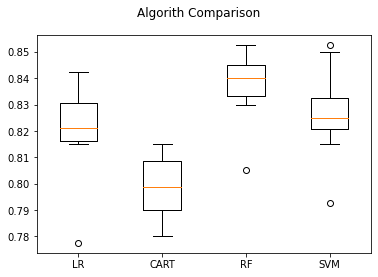

In [46]:
# Plot the comparision between all models created.

fig = plt.figure()
fig.suptitle('Algorith Comparison')
ax = fig.add_subplot()
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

In [47]:
# Tune Random Forest

# Test for multiple estimators and max features
n_estimators = np.array([50,100,150,200,250])
max_features = np.array([1,2,3,4,5])

param_grid = dict(n_estimators=n_estimators,max_features=max_features)
model3 = RandomForestClassifier()

# Using 10 splits in Kfold 
kfold = KFold(n_splits=10)

#GridSearchCV to automate the tuning of hyperparameters.
grid = GridSearchCV(estimator=model3, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train2, y_train2)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.845000 using {'max_features': 1, 'n_estimators': 50}
0.845000 (0.019429) with: {'max_features': 1, 'n_estimators': 50}
0.841000 (0.017685) with: {'max_features': 1, 'n_estimators': 100}
0.838500 (0.016628) with: {'max_features': 1, 'n_estimators': 150}
0.842750 (0.017409) with: {'max_features': 1, 'n_estimators': 200}
0.845000 (0.017103) with: {'max_features': 1, 'n_estimators': 250}
0.839750 (0.019540) with: {'max_features': 2, 'n_estimators': 50}
0.837500 (0.017854) with: {'max_features': 2, 'n_estimators': 100}
0.840000 (0.020917) with: {'max_features': 2, 'n_estimators': 150}
0.842750 (0.020324) with: {'max_features': 2, 'n_estimators': 200}
0.841500 (0.019242) with: {'max_features': 2, 'n_estimators': 250}
0.841750 (0.020126) with: {'max_features': 3, 'n_estimators': 50}
0.842000 (0.019774) with: {'max_features': 3, 'n_estimators': 100}
0.839750 (0.019185) with: {'max_features': 3, 'n_estimators': 150}
0.839250 (0.023320) with: {'max_features': 3, 'n_estimators': 200}
0.84

In [49]:
# After the Random forest is tuned we can finally create a model using RF (final model)

random_forest = RandomForestClassifier(n_estimators=250, max_features=3)
random_forest.fit(X_train2, y_train2)

# predict test data
predictions = random_forest.predict(X_test2)

In [50]:
# View accuracy score for test data and predictions

print("Accuracy: %s%%" % (100*accuracy_score(y_test2, predictions)))

Accuracy: 83.2%


In [51]:
# View confusion matrix for test data and predictions

print(confusion_matrix(y_test2, predictions))

[[664  72]
 [ 96 168]]


In [52]:
# View the classification report for test data and predictions

print(classification_report(y_test2, predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89       736
         1.0       0.70      0.64      0.67       264

    accuracy                           0.83      1000
   macro avg       0.79      0.77      0.78      1000
weighted avg       0.83      0.83      0.83      1000



In [53]:
# Predict the missing Income values

predictions_wo_income_val = random_forest.predict(X_for_predict)

In [54]:
# look at predicted values

predictions_wo_income_val

array([1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0.

In [55]:
# Predicted values with it's respective information

X_for_predict.reset_index(inplace=True)
# Adding Income column
X_for_predict['Income'] = pd.DataFrame(predictions_wo_income_val)
# Resetting Income column values to it's original values.
X_for_predict['Income'].replace({0:'<=50K', 1:'>50K'}, inplace=True)

In [56]:
# look at data: all predicted

X_for_predict

,index,Age,Weighing_Factor,Duration_of_Education,Capital_Gain,Capital_Loss,Weekely_Working_Hours,Male,Single,Income
0,5000,0.410959,0.045736,0.933333,0.278283,0.000000,0.500000,1.0,1.0,>50K
1,5001,0.520548,0.094531,0.800000,0.000000,0.365014,0.377551,0.0,1.0,<=50K
2,5002,0.123288,0.081754,0.533333,0.050131,0.000000,0.397959,0.0,0.0,<=50K
3,5003,0.150685,0.101458,0.533333,0.000000,0.000000,0.397959,0.0,1.0,<=50K
4,5004,0.260274,0.033999,0.533333,0.000000,0.000000,0.397959,1.0,0.0,<=50K
...,...,...,...,...,...,...,...,...,...,...
24995,29995,0.178082,0.029337,0.866667,0.000000,0.000000,0.448980,1.0,1.0,<=50K
24996,29996,0.424658,0.072796,0.666667,0.000000,0.000000,0.561224,1.0,0.0,>50K
24997,29997,0.602740,0.105311,0.600000,0.000000,0.000000,0.346939,1.0,0.0,<=50K
24998,29998,0.328767,0.116878,0.533333,0.000000,0.000000,0.397959,1.0,1.0,<=50K


In [57]:
# Importance of each attribut

importances = list(random_forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train2.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

[0.19578698390160093, 0.2421586892840442, 0.12588282870573722, 0.11799552500709456, 0.038983010912165494, 0.09787820637120401, 0.01977065616479862, 0.16154409965335495]
Variable: Weighing_Factor      Importance: 0.24
Variable: Age                  Importance: 0.2
Variable: Single               Importance: 0.16
Variable: Duration_of_Education Importance: 0.13
Variable: Capital_Gain         Importance: 0.12
Variable: Weekely_Working_Hours Importance: 0.1
Variable: Capital_Loss         Importance: 0.04
Variable: Male                 Importance: 0.02


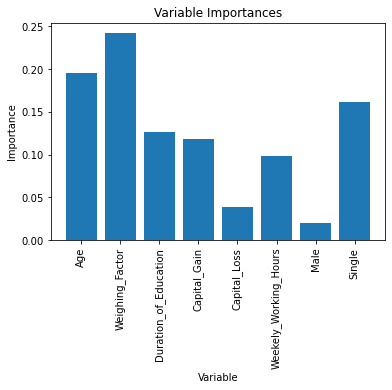

In [58]:
#Visualize the importance of each attribute

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, X_train2.columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

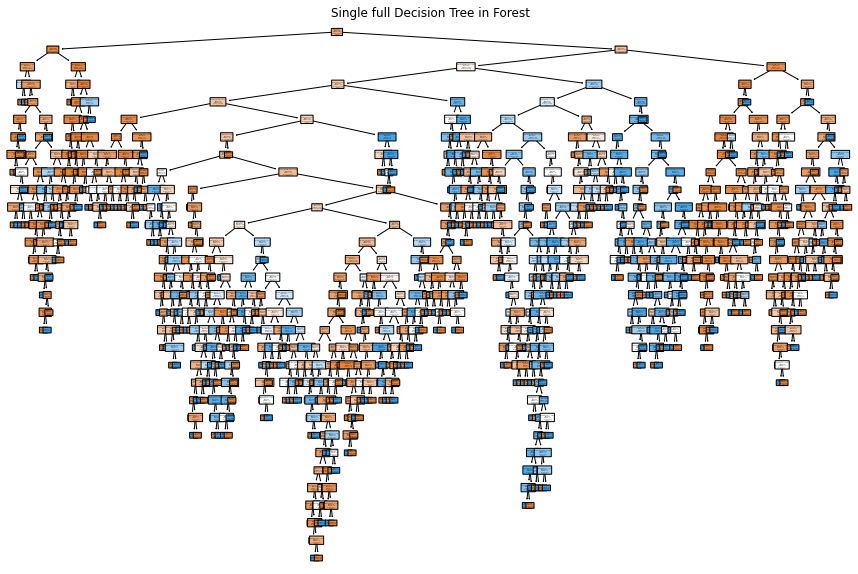

In [59]:
# Plotting one complete single tree from forest

fig = plt.figure(figsize=(15, 10))
plot_tree(random_forest.estimators_[0], 
          feature_names=X_train1.columns,
          class_names='Income', 
          filled=True, impurity=True, 
          rounded=True)

plt.title('Single full Decision Tree in Forest')
fig.savefig('rf_individualtree.png')

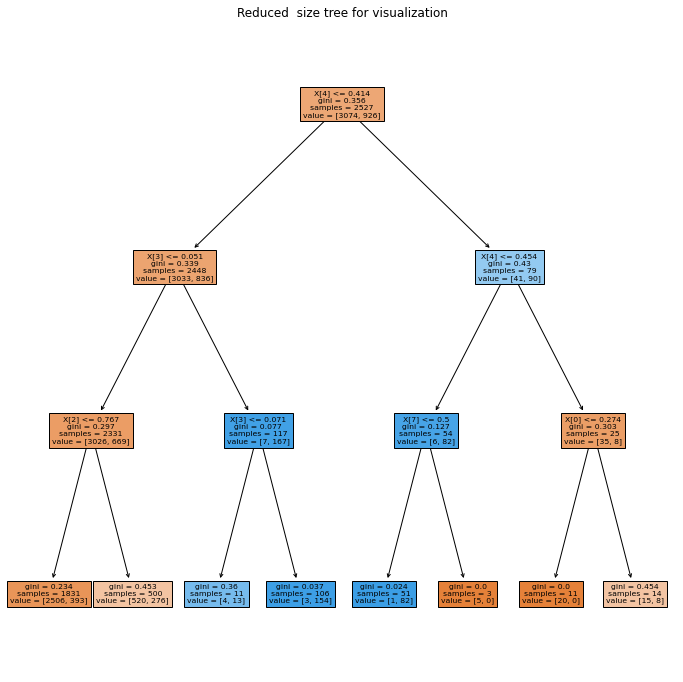

In [53]:
# Limit depth of tree to 3 levels

rf = RandomForestClassifier(n_estimators=10, max_depth=3)  
rf.fit(X_train2, y_train2)

# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
plot_tree(rf.estimators_[0], filled=True)
plt.title('Reduced  size tree for visualization')
plt.show()

Summary: Due to few missing data for 3 attributes, I have to handle the missing data by substituting them with mode or new value. After that we splitted the with not null Income attribute and applied few ML algorithms. Using accuracy, we found that Random Forest is working best for given dataset in predicting the income. I tuned the Random Forest to see on what parameters it performs the best. Then I genereted the final Random forest model and predicted income for missing data. 